In [8]:
import django
import pandas as pd
import requests
django.setup()

In [2]:
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

from sch.models import *
import datetime as dt
from django.db.models import CharField
from django.test import RequestFactory
from sch.actions import *
from sch.views2 import *
from django.db.models import Sum

In [3]:
josh_op = Slot.objects.filter(employee__name='Josh',shift__name='OP')
print([op.workday.days_away for op in josh_op])

[-50, -43, -14, -1, 19, 27, 103, 124, 139]


In [4]:
tallies = tally(list(Slot.objects.filter(shift__name="OP").values_list('employee__name',flat=True)))
df = pd.DataFrame.from_dict(sortDict(tallies,reverse=True), orient='index', columns=['count'])
df

,count
Brittanie,185
Leslie,19
Josh,9
Mandy,5
Trisha,4
Elisia,4
Mark,2
Cheryl,2
Mona,2
Nick,2


<AxesSubplot:>

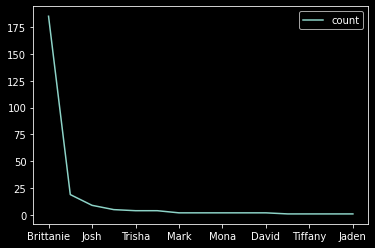

In [5]:
df.plot()

In [6]:
sch = Schedule.objects.first()

empls = Employee.objects.annotate(scheduleHours=Sum('slots__shift__hours')).order_by('-scheduleHours')
# standard schedule Hours should be 240 * the employees fte field
empls = empls.annotate(standardScheduleHours=240*F('fte'))
empls = empls.annotate(percentScheduled=F('scheduleHours')/F('standardScheduleHours')*100)
data = empls.values('name','scheduleHours','standardScheduleHours','percentScheduled')
df = pd.DataFrame.from_records(data)
df

,name,scheduleHours,standardScheduleHours,percentScheduled
0,Brianna A,1760.0,240.0,733.333333
1,Jaden,1738.0,240.0,724.166667
2,Elisia,1732.0,240.0,721.666667
3,Danica,1710.0,240.0,712.500000
4,Cheryl,1636.0,240.0,681.666667
5,Brittanie,1620.0,240.0,675.000000
6,Esperanza,1620.0,240.0,675.000000
7,Mona,1596.0,240.0,665.000000
8,David,1566.0,240.0,652.500000
9,Josh,1492.0,150.0,994.666667


In [11]:
def sch_solve_with_lookbehind (request, schid):
    sch = Schedule.objects.get(slug=schid)
    success_bucket = []
    emptySlots = sch.slots.empty().order_by('?')
    for slot in emptySlots:
        if slot.workday.sd_id != 0:
            prev = slot.workday.prevWD().slots.filter(shift__start__hour__lte=slot.shift.start.hour+1, shift__start__hour__gte=slot.shift.start.hour-1)
            choices = []
            for p in prev:
                if p.streak < p.employee.streak_pref and p.employee not in choices and p.employee in slot.workday.on_deck():
                    choices.append(p.employee)
            if len(choices) > 0:
                chosen = random.choice(choices)
                if PtoRequest.objects.filter(employee=chosen, workday=slot.workday.date).exists() == False:
                    if TemplatedDayOff.objects.filter(employee=chosen, sd_id=slot.workday.sd_id).exists() == False:
                        try:
                            slot.employee = chosen
                            slot.save()
                            success_bucket.append(slot)
                        except:
                            print(f"ERROR: {slot} could not be filled")
                    else: 
                        print(f"{chosen} has a templated day off on {slot.workday.date}")
                else:
                    print(f"{chosen} has a PTO request on {slot.workday.date}")
            else:
                print(f"No choices for {slot}")
                try:
                    slot.employee = random.choice(workday.on_deck())
                    slot.save()
                    success_bucket.append(slot)
                except:
                    print(f"ERROR: Backup Fill via On Deck Employees Failed. This slot was not filled. {slot}")
        else:
            print(f"{slot} is on First Sunday of Schedule")
    print(len(success_bucket) , "slots filled via method SCHEDULE_SOLVE_WITH_LOOKBEHIND")
                    

In [12]:
sch_solve_with_lookbehind(None, '2022-S8A')

['Mona', 'Esperanza', 'Michael', None, 'Jaden', 'Leslie', 'Josh', 'Brittanie', 'Cheryl', 'David', 'Brianna-A', None]
No choices for 221206-N None
ERROR: Backup Fill via On Deck Employees Failed. This slot was not filled. 221206-N None
['Mona', 'Esperanza', 'Michael', None, 'Jaden', 'Leslie', 'Josh', 'Brittanie', 'Cheryl', 'David', 'Brianna-A', None]
['Mona', 'Esperanza', 'Michael', None, 'Jaden', 'Leslie', 'Josh', 'Brittanie', 'Cheryl', 'David', 'Brianna-A', None]
1 slots filled via method SCHEDULE_SOLVE_WITH_LOOKBEHIND


In [13]:
valList = lambda list_ , val : list(list_.values_list(val,flat=True))